# **Bi-Dimensional**<br/>
**Master's Degree in Data Science (A.Y. 2023/2024)**<br/>
**University of Milano - Bicocca**<br/>

Vittorio Haardt, Luca Porcelli

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Data Extraction Train

In [ ]:
!unzip "/content/drive/MyDrive/Digital/Data/Imm.zip" -d Data

# Installing packages and loading libraries

In [ ]:
pip install efficientnet

In [ ]:
pip install tensorflow-addons

In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models
from efficientnet.keras import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
import os
import shutil
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageFilter, ImageChops
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Dense
from keras.optimizers import Adam
import tensorflow_addons as tfa
from keras.models import load_model
from collections import OrderedDict
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Pre-Processing

## Removing Non-Interest Classes and Filtering Unsupported Images

Ahegao class deletion and image removals in non-compatible formats

In [ ]:
# Main directory path
main_folder = '/content/Data/dataset'

# Directory to be deleted
folder_to_delete = os.path.join(main_folder, 'Ahegao')
shutil.rmtree(folder_to_delete)

# List of allowed file extensions
allowed_extensions = ['.jpg', '.jpeg', '.png']

# Function to check if a file has an allowed extension
def is_allowed_extension(file):
    return any(file.lower().endswith(ext) for ext in allowed_extensions)

# Iterate through the main folder and its subdirectories
for parent_folder, _, files in os.walk(main_folder):
    for file in files:
        file_path = os.path.join(parent_folder, file)
        # Check if the file has an allowed extension
        if not is_allowed_extension(file):
            # If not allowed, remove the file
            os.remove(file_path)
            print(f"Deleted file: {file_path}")

## Dataset balancing

The distribution of image frequencies by class

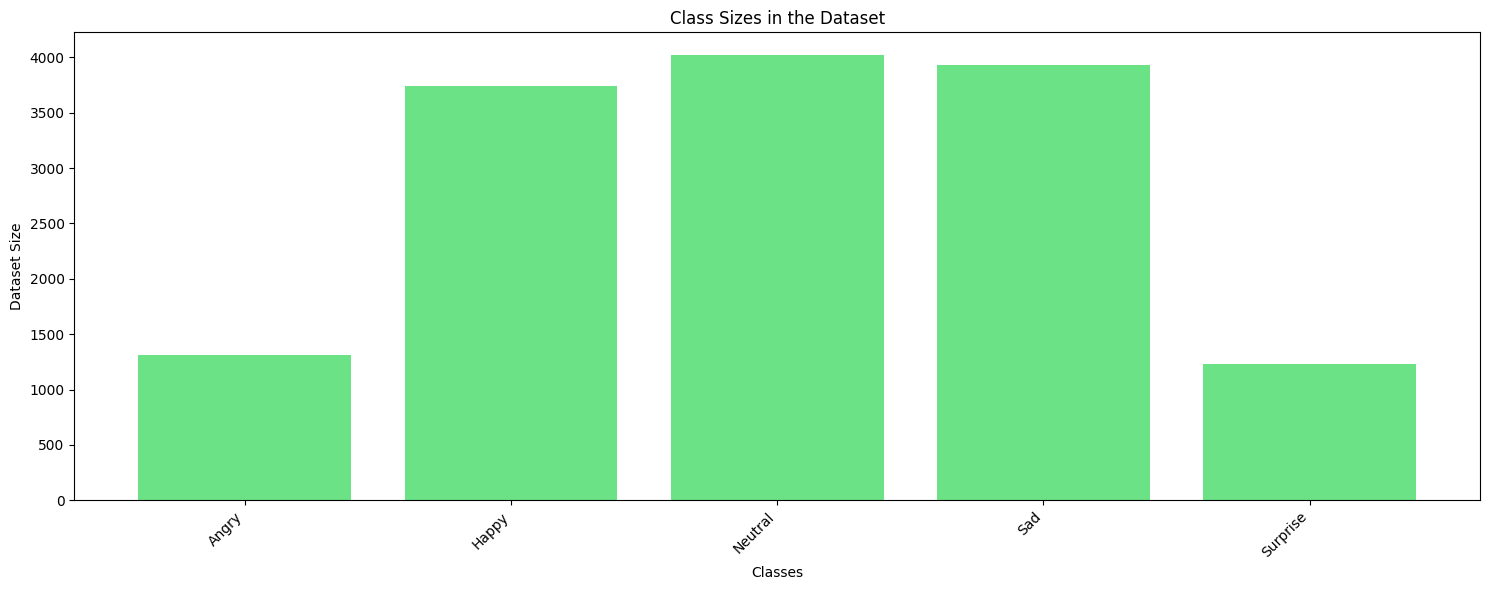

In [ ]:
# Define the path of the original folder
original_data_dir = '/content/Data/dataset'

# Get the list of all classes in your dataset
all_classes = sorted(os.listdir(original_data_dir))

# Calculate the original sizes of the classes
original_sizes = [len(os.listdir(os.path.join(original_data_dir, class_label))) for class_label in all_classes]

# Choose a random pastel color
pastel_color = "#{:06x}".format(random.randint(0, 0xFFFFFF))

# Create the bar chart without values above the bars
plt.figure(figsize=(15, 6))
bars = plt.bar(all_classes, original_sizes, color=pastel_color)  # Random pastel color

plt.xlabel('Classes')
plt.ylabel('Dataset Size')
plt.title('Class Sizes in the Dataset')

# Show class labels on the x-axis
plt.xticks(rotation=45, ha='right')
plt.xticks(range(len(all_classes)), all_classes)

plt.tight_layout()
plt.show()

Undersampling

In [10]:
# Set the seed for reproducibility
seed_value = 777
random.seed(seed_value)

# Path to the main folder
main_folder = "/content/Data/dataset"

# Create a new folder for the selected files
new_folder = "/content/Data/dataset_new"
os.makedirs(new_folder, exist_ok=True)

# Dictionary to track the distribution of file quantities in the old subfolders
old_folder_distribution = {}

# Find the subfolder with the fewest files
min_num_files = float('inf')

# Iterate through the sorted subfolders
for emotion in sorted(os.listdir(main_folder)):
    emotion_subfolder = os.path.join(main_folder, emotion)

    # Sort the list of files in the subfolder
    file_list = sorted(os.listdir(emotion_subfolder))

    num_files = len(file_list)
    old_folder_distribution[emotion] = num_files

    if num_files < min_num_files:
        min_num_files = num_files

# Dictionary to track the distribution of file quantities in the new subfolders
new_folder_distribution = {}

# Iterate through the sorted subfolders
for emotion in sorted(os.listdir(main_folder)):
    emotion_subfolder = os.path.join(main_folder, emotion)

    # Sort the list of files in the subfolder
    file_list = sorted(os.listdir(emotion_subfolder))

    # Randomly select 'min_num_files' files from the current subfolder
    selected_files = random.sample(file_list, min_num_files)

    # Create a new subfolder in the destination folder
    new_subfolder = os.path.join(new_folder, emotion)
    os.makedirs(new_subfolder, exist_ok=True)

    new_folder_distribution[emotion] = min_num_files

    # Copy the selected files to the new subfolder
    for file in selected_files:
        source_file = os.path.join(emotion_subfolder, file)
        destination_file = os.path.join(new_subfolder, file)
        shutil.copyfile(source_file, destination_file)

# Data Augmentation

In [6]:
# Creating an image generator with various transformations for data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,          # Maximum rotation angle in degrees
    zoom_range=0.2,             # Random zoom
    horizontal_flip=True,       # Randomly flip images horizontally
)

# Train/Val/Test

In [7]:
encoder=OneHotEncoder()
encoder.fit([[0],[1],[2],[3],[4]])

OneHotEncoder()

In [8]:
data=[]
paths=[]
result=[]

In [9]:
paths=[]
for r,d,f in os.walk('/content/Data/dataset_new/Angry'):
    for file in f:
        if '.jpg' or '.png' in file:
            paths.append(os.path.join(r,file))
for path in paths:
    img=Image.open(path)
    img=img.resize((224,224))
    img=np.array(img)
    if (img.shape==(224,224,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[0]]).toarray())

In [10]:
paths=[]
for r,d,f in os.walk('/content/Data/dataset_new/Happy'):
    for file in f:
        if '.jpg' or '.png' in file:
            paths.append(os.path.join(r,file))
for path in paths:
    img=Image.open(path)
    img=img.resize((224,224))
    img=np.array(img)
    if (img.shape==(224,224,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[1]]).toarray())

In [11]:
paths=[]
for r,d,f in os.walk('/content/Data/dataset_new/Neutral'):
    for file in f:
        if '.jpg' or '.png' in file:
            paths.append(os.path.join(r,file))
for path in paths:
    img=Image.open(path)
    img=img.resize((224,224))
    img=np.array(img)
    if (img.shape==(224,224,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[2]]).toarray())

In [12]:
paths=[]
for r,d,f in os.walk('/content/Data/dataset_new/Sad'):
    for file in f:
        if '.jpg' or '.png' in file:
            paths.append(os.path.join(r,file))
for path in paths:
    img=Image.open(path)
    img=img.resize((224,224))
    img=np.array(img)
    if (img.shape==(224,224,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[3]]).toarray())

In [13]:
paths=[]
for r,d,f in os.walk('/content/Data/dataset_new/Surprise'):
    for file in f:
        if '.jpg' or '.png' in file:
            paths.append(os.path.join(r,file))
for path in paths:
    img=Image.open(path)
    img=img.resize((224,224))
    img=np.array(img)
    if (img.shape==(224,224,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[4]]).toarray())

In [14]:
data=np.array(data)
data.shape

(6170, 224, 224, 3)

In [15]:
result=np.array(result)
result=result.reshape(6170,5)

In [16]:
# Train test
x_train, x_test, y_train, y_test = train_test_split(data, result, test_size=0.2, shuffle=True, random_state=777)
#Train val
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, random_state=777)

In [17]:
# Data Augmentation
datagen.fit(x_train)

# Models

## Model

### Structure

This structure represents a convolutional neural network (CNN). It consists of convolutional layers followed by batch normalization, ReLU activation, max pooling and dropout. Next, there are densely connected layers and an output layer with softmax activation function.

In [ ]:
model = Sequential()

model.add(Conv2D(64,(3,3), padding='same', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))

opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

### Training

In [ ]:
# Definition of a function for learning rate scheduling
def decay_schedule(epoch, lr):
    # Check if the epoch is a multiple of 10 and if the epoch is not zero
    if (epoch % 10 == 0) and (epoch != 0):
        # Reduce the learning rate by 50%
        lr = lr * 0.5
    # Return the new learning rate value
    return lr

# Creating a LearningRateScheduler object using the learning rate schedule function
lr_scheduler = LearningRateScheduler(decay_schedule)

# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',               # Monitors validation loss
    patience=10,                      # Number of epochs with no improvement before stopping
    verbose=1,                        # Prints messages about early stopping
    restore_best_weights=True         # Restores model weights from the epoch with the best value of the monitored quantity
)

checkpoint_filepath = '/content/drive/MyDrive/Digital/Models/Bi-Dimensional/best_model_conv_color.h5'
best_model = ModelCheckpoint(checkpoint_filepath,
                             verbose=1,
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             save_weights_only=False)

In [ ]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=64)
                    epochs=50,
                    verbose=1,
                    validation_data=(x_val,y_val),
                    callbacks=[lr_scheduler, early_stop, best_model])

Epoch 1/50
62/62 [==============================] - ETA: 0s - loss: 1.6423 - accuracy: 0.3536
Epoch 1: val_loss improved from inf to 1.56352, saving model to /content/drive/MyDrive/Digital/Models/Bi-Dimensional/best_model_conv_color.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


62/62 [==============================] - 53s 798ms/step - loss: 1.6423 - accuracy: 0.3536 - val_loss: 1.5635 - val_accuracy: 0.2551 - lr: 1.0000e-04
Epoch 2/50
62/62 [==============================] - ETA: 0s - loss: 1.4070 - accuracy: 0.4362
Epoch 2: val_loss improved from 1.56352 to 1.52542, saving model to /content/drive/MyDrive/Digital/Models/Bi-Dimensional/best_model_conv_color.h5
62/62 [==============================] - 45s 727ms/step - loss: 1.4070 - accuracy: 0.4362 - val_loss: 1.5254 - val_accuracy: 0.3563 - lr: 1.0000e-04
Epoch 3/50
62/62 [==============================] - ETA: 0s - loss: 1.2599 - accuracy: 0.4954
Epoch 3: val_loss improved from 1.52542 to 1.51052, saving model to /content/drive/MyDrive/Digital/Models/Bi-Dimensional/best_model_conv_color.h5
62/62 [==============================] - 49s 795ms/step - loss: 1.2599 - accuracy: 0.4954 - val_loss: 1.5105 - val_accuracy: 0.3634 - lr: 1.0000e-04
Epoch 4/50
62/62 [==============================] - ETA: 0s - loss: 1.127

### Model performance graphs

In [ ]:
import plotly.graph_objects as go

# Loss
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history.history['loss']) + 1)),
    y=history.history['loss'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history.history['val_loss']) + 1)),
    y=history.history['val_loss'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Loss',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()

# Accuracy
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history.history['accuracy']) + 1)),
    y=history.history['accuracy'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history.history['val_accuracy']) + 1)),
    y=history.history['val_accuracy'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Accuracy',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Accuracy'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()


In [ ]:
loaded_model = load_model('/content/drive/MyDrive/Digital/Models/Bi-Dimensional/best_model_conv_color.h5')

In [ ]:
loaded_model.evaluate(x_test, y_test)

39/39 [==============================] - 7s 97ms/step - loss: 1.1414 - accuracy: 0.5632


[1.141416072845459, 0.563209056854248]

## ResNet50

### Structure

Neural network model using ResNet50 as a pretrained base on ImageNet and adds some custom layers to fit the model to the data

In [ ]:
# Pretrained ResNet50 base model with ImageNet weights
base_net = keras.applications.ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
base_net.trainable = False  # Setting the layers of the base model as non-trainable

# Explicitly creating the input layer
inputs = keras.Input(shape=(224, 224, 3))
x = inputs

# Preprocessing the input using the ResNet50 preprocessing function
x = keras.applications.resnet50.preprocess_input(x)

# Passing the preprocessed input through the base model
x = base_net(x)

# GlobalAveragePooling2D to reduce spatial dimensions
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.3)(x)  # Dropout for regularization

# Adding a dense layer for final classification with L2 regularization
outputs = keras.layers.Dense(5, activation='softmax', kernel_regularizer=keras.regularizers.l2(0.01))(x)

# Creating the specialized ResNet50 model
Resnet50 = keras.Model(inputs=inputs, outputs=outputs)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
# Definition of a function for learning rate scheduling
def decay_schedule(epoch, lr):
    # Check if the epoch is a multiple of 10 and if the epoch is not zero
    if (epoch % 10 == 0) and (epoch != 0):
        # Reduce the learning rate by 50%
        lr = lr * 0.5
    # Return the new learning rate value
    return lr

# Creating a LearningRateScheduler object using the learning rate schedule function
lr_scheduler = LearningRateScheduler(decay_schedule)

# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',               # Monitors validation loss
    patience=10,                      # Number of epochs with no improvement before stopping
    verbose=1,                        # Prints messages about early stopping
    restore_best_weights=True         # Restores model weights from the epoch with the best value of the monitored quantity
)

checkpoint_filepath = '/content/drive/MyDrive/Digital/Models/Bi-Dimensional/best_model_ResNet50_color.h5'
best_model = ModelCheckpoint(checkpoint_filepath,
                             verbose=1,
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             save_weights_only=False)

### Training

In [ ]:
# Compiling the model for training
Resnet50.compile(
    loss='categorical_crossentropy',   # Categorical crossentropy loss for multi-class classification
    optimizer=Adam(0.001),             # Adam optimizer with a learning rate of 0.001
    metrics=['accuracy']               # Metrics for evaluation during training
)

# Training the model
history = Resnet50.fit(datagen.flow(x_train, y_train, batch_size=64),
                       epochs=50,
                       verbose=1,
                       validation_data=(x_val,y_val),
                       callbacks=[lr_scheduler, early_stop, best_model])

Epoch 1/50
62/62 [==============================] - ETA: 0s - loss: 1.7128 - accuracy: 0.3579
Epoch 1: val_loss improved from inf to 1.34113, saving model to /content/drive/MyDrive/Digital/Models/Bi-Dimensional/best_model_ResNet50_color.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


62/62 [==============================] - 78s 1s/step - loss: 1.7128 - accuracy: 0.3579 - val_loss: 1.3411 - val_accuracy: 0.5101 - lr: 0.0010
Epoch 2/50
62/62 [==============================] - ETA: 0s - loss: 1.4274 - accuracy: 0.4724
Epoch 2: val_loss improved from 1.34113 to 1.22676, saving model to /content/drive/MyDrive/Digital/Models/Bi-Dimensional/best_model_ResNet50_color.h5
62/62 [==============================] - 53s 865ms/step - loss: 1.4274 - accuracy: 0.4724 - val_loss: 1.2268 - val_accuracy: 0.5486 - lr: 0.0010
Epoch 3/50
62/62 [==============================] - ETA: 0s - loss: 1.3001 - accuracy: 0.5228
Epoch 3: val_loss improved from 1.22676 to 1.18307, saving model to /content/drive/MyDrive/Digital/Models/Bi-Dimensional/best_model_ResNet50_color.h5
62/62 [==============================] - 54s 862ms/step - loss: 1.3001 - accuracy: 0.5228 - val_loss: 1.1831 - val_accuracy: 0.5577 - lr: 0.0010
Epoch 4/50
62/62 [==============================] - ETA: 0s - loss: 1.2356 - acc

### Model performance graphs

In [ ]:
import plotly.graph_objects as go

# Loss
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history.history['loss']) + 1)),
    y=history.history['loss'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history.history['val_loss']) + 1)),
    y=history.history['val_loss'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Loss',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()

# Accuracy
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history.history['accuracy']) + 1)),
    y=history.history['accuracy'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history.history['val_accuracy']) + 1)),
    y=history.history['val_accuracy'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Accuracy',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Accuracy'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()


In [ ]:
Resnet = load_model('/content/drive/MyDrive/Digital/Models/Bi-Dimensional/best_model_ResNet50_color.h5')

In [ ]:
Resnet.evaluate(x_test, y_test)

39/39 [==============================] - 6s 132ms/step - loss: 1.0351 - accuracy: 0.6272


[1.0350756645202637, 0.6272284984588623]

## ResNet50 Different Learning Rate

### Structure

In [23]:
# Pretrained ResNet50 base model with ImageNet weights
base_net = keras.applications.ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
base_net.trainable = True  # Setting the layers of the base model as non-trainable

# Explicitly creating the input layer
inputs = keras.Input(shape=(224, 224, 3))
x = inputs

# Preprocessing the input using the ResNet50 preprocessing function
x = keras.applications.resnet50.preprocess_input(x)

# Passing the preprocessed input through the base model
x = base_net(x)

# GlobalAveragePooling2D to reduce spatial dimensions
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.3)(x)  # Dropout for regularization

# Adding a dense layer for final classification with L2 regularization
outputs = keras.layers.Dense(5, activation='softmax', kernel_regularizer=keras.regularizers.l2(0.01))(x)

# Creating the specialized ResNet50 model
Resnet50 = keras.Model(inputs=inputs, outputs=outputs)

94765736/94765736 [==============================] - 0s 0us/step


In [24]:
# Definition of a function for learning rate scheduling
def decay_schedule(epoch, lr):
    # Check if the epoch is a multiple of 10 and if the epoch is not zero
    if (epoch % 10 == 0) and (epoch != 0):
        # Reduce the learning rate by 50%
        lr = lr * 0.5
    # Return the new learning rate value
    return lr

# Creating a LearningRateScheduler object using the learning rate schedule function
lr_scheduler = LearningRateScheduler(decay_schedule)

# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',               # Monitors validation loss
    patience=10,                      # Number of epochs with no improvement before stopping
    verbose=1,                        # Prints messages about early stopping
    restore_best_weights=True         # Restores model weights from the epoch with the best value of the monitored quantity
)

checkpoint_filepath = '/content/drive/MyDrive/Digital/Models/Bi-Dimensional/best_model_ResNet50_color_lr.h5'
best_model = ModelCheckpoint(checkpoint_filepath,
                             verbose=1,
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             save_weights_only=False)

### Training

1. Defined two initial learning rates.
2. One cycle is run for a total of 50 epochs.
3. Within the cycle, two Adam optimizers are created with corresponding learning rates, which will be associated, one with the ResNet and one for the added levels.
4. After each epoch, the learning rates are reduced by half. This is a method to dynamically adjust the learning rate during training to improve model convergence.

In [ ]:
# Training the model
lr1=0.00001
lr2=0.001

for i in range(5):
  optimizers = [
      tf.keras.optimizers.Adam(learning_rate=lr1),
      tf.keras.optimizers.Adam(learning_rate=lr2)
  ]
  optimizers_and_layers = [(optimizers[0], Resnet50.layers[:4]), (optimizers[1], Resnet50.layers[4:])]
  optimizer = tfa.optimizers.MultiOptimizer(optimizers_and_layers)
  Resnet50.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

  # Training the model
  history = Resnet50.fit(datagen.flow(x_train, y_train, batch_size=64),epochs=10, verbose=1,validation_data=(x_val,y_val), callbacks=[best_model])
  lr1=lr1*0.5
  lr2=lr2*0.5

Epoch 1/10
62/62 [==============================] - ETA: 0s - loss: 1.6058 - accuracy: 0.3951
Epoch 1: val_loss improved from inf to 1.40404, saving model to /content/drive/MyDrive/Digital/Models/Bi-Dimensional/best_model_ResNet50_color_lr.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


62/62 [==============================] - 130s 1s/step - loss: 1.6058 - accuracy: 0.3951 - val_loss: 1.4040 - val_accuracy: 0.4433
Epoch 2/10
62/62 [==============================] - ETA: 0s - loss: 1.2144 - accuracy: 0.5512
Epoch 2: val_loss improved from 1.40404 to 1.21997, saving model to /content/drive/MyDrive/Digital/Models/Bi-Dimensional/best_model_ResNet50_color_lr.h5
62/62 [==============================] - 70s 1s/step - loss: 1.2144 - accuracy: 0.5512 - val_loss: 1.2200 - val_accuracy: 0.5617
Epoch 3/10
62/62 [==============================] - ETA: 0s - loss: 1.0227 - accuracy: 0.6474
Epoch 3: val_loss improved from 1.21997 to 0.95515, saving model to /content/drive/MyDrive/Digital/Models/Bi-Dimensional/best_model_ResNet50_color_lr.h5
62/62 [==============================] - 67s 1s/step - loss: 1.0227 - accuracy: 0.6474 - val_loss: 0.9552 - val_accuracy: 0.6518
Epoch 4/10
62/62 [==============================] - ETA: 0s - loss: 0.9226 - accuracy: 0.6755
Epoch 4: val_loss improv

In [22]:
Resnet = load_model('/content/drive/MyDrive/Digital/Models/Bi-Dimensional/best_model_ResNet50_color_lr.h5', compile=False)

In [23]:
optimizers = [
    tf.keras.optimizers.Adam(learning_rate=1.25e-06),
    tf.keras.optimizers.Adam(learning_rate=0.000125)
]
optimizers_and_layers = [(optimizers[0], Resnet.layers[:4]), (optimizers[1], Resnet.layers[4:])]
optimizer = tfa.optimizers.MultiOptimizer(optimizers_and_layers)
Resnet.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["categorical_accuracy",'accuracy'])

In [24]:
Resnet.evaluate(x_test, y_test)

39/39 [==============================] - 11s 123ms/step - loss: 0.7689 - categorical_accuracy: 0.7423 - accuracy: 0.7423


[0.7688983678817749, 0.7423014640808105, 0.7423014640808105]

39/39 [==============================] - 4s 85ms/step


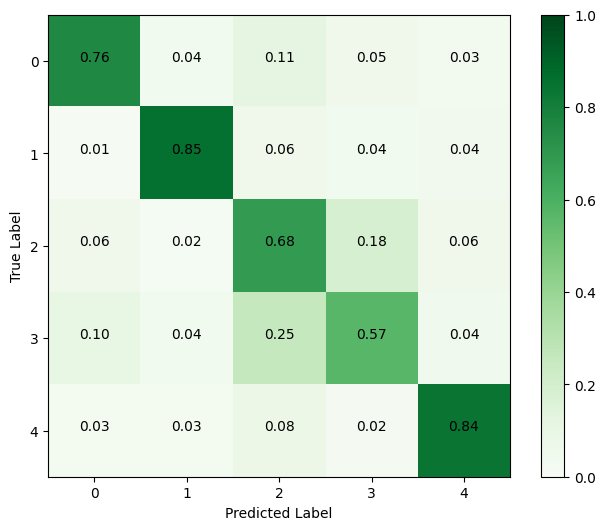

In [26]:
# Predict labels for test set
y_pred = Resnet.predict(x_test)
y_p=np.argmax(y_pred, axis=1)
y_t=np.argmax(y_test, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_t, y_p)

# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

# Plot confusion matrix with green blocks
plt.figure(figsize=(8, 6))
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Greens)

# Add numbers to the plot
thresh = cm_normalized.max() / 2.
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        plt.text(j, i, format(cm_normalized[i, j], '.2f'),
                 horizontalalignment="center",
                 color="black")

# Customize color bar limits
plt.colorbar()
plt.clim(0, 1)  # Setting color bar limits from 0 to 1
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()